In [2]:
# Preliminaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from IPython.display import Image
import os,sys

SRC_PATH = '../../src/'
sys.path.insert(0, os.path.normpath(os.path.join(os.path.abspath(''), SRC_PATH)))

from plot_utils import *
from plot_utils import VARIATION, RED_COLORS

# The Multi-tier framework for measuring energy access

This notebook analized the energy access data published by the 
[ESMAP Sector of the World Bank](https://mtfenergyaccess.esmap.org/country/rwanda), related to the energy access assessment
in Rwanda.

The assessment is based on the [Multi-Tier Framework](). In this approach, energy access is evaluated across a range of dimensions (called *attributes*). Along each attribute, each household is ranked in a 
**tier** (a level), from 0 (no access to energy) to 5 (full access to energy). The final energy access ranking
is then defined as the **minimum** over all attributed.

The report concerning the study in Rwanda can be downloaded [here](https://energydata.info/dataset/rwanda-multi-tier-framework-mtf-survey-2018)



## Structure of the Database

The questionnaire consists of the following Sections.

- Section A: Household hoster, informations about the people of the household and their situation.

- Section B: Household Characteristics (general informations about the habitat, water, bank, etc.)

- Section C: Supply of Electricity

- Section D: Willingness to pay for a Grid Connection

- Section E: Willingness to pay for Solar Device 

- Section F: Kerosene/Fuel-based/Candle Lighting

- Section G: Dry-Celle Batteries

- Section H: Household Fuel Consumption

- Section I: Use of Cookng Solutions

- Section J: Space and wtaer heating 

- Section K: Willigness to pay for an Improved cookstove 

- Section L: Transportation and agricultural equipment ownership.

- Section M: Household Land Ownership

- Section N: Household Economic Shocks

- Section O: Street Lighting 

- Section P: Time Use

- Section Q: Health impacts

- Section R: Attitudes, Satisfactions

- Section S: Women's Empowerment

- Section T: Household based business/entreprise



In [3]:
# TODO in this cell:
# - read all the relevant data
# - define some important variables (such as n of households, )

main = pd.read_excel('../raw_data/main.xlsx')
section_I = pd.read_csv('../raw_data/csv/I.csv')

# This might not be necessary
codebook_I = pd.read_excel('../references/codebook.xlsx', sheet_name= 'Section I')

n_households = len(main)

In [26]:
# Quick look on the main dataset
main.head()

,Unnamed: 0,Household Identification,Cluster,strata,Province,District,Sector,Cellule,Village,Respondent id,...,T28b_Size,T28c_What are the solar devices used for,DATE_START,TIME_START,DATE_END,TIME_END,Cluster.1,Basic sample weight calculation and calibration process,Locality,habitat
0,0,1102020811001,1,11,City of Kigali,Nyarugenge,Kanyinya,Nzove,Ruyenzi,2,...,NaN,NaN,2016-11-18,12:05:00,2016-11-18,12:49:00,11,476617645263672,0,urban
1,1,1102020811002,1,12,City of Kigali,Nyarugenge,Kanyinya,Nzove,Ruyenzi,1,...,NaN,NaN,2016-11-18,10:23:00,2016-11-18,11:26:00,12,370042022705078,0,urban
2,2,1102020811003,1,12,City of Kigali,Nyarugenge,Kanyinya,Nzove,Ruyenzi,1,...,NaN,NaN,2016-11-18,11:32:00,2016-11-18,12:24:00,12,370042022705078,0,urban
3,3,1102020811004,1,12,City of Kigali,Nyarugenge,Kanyinya,Nzove,Ruyenzi,1,...,NaN,NaN,2016-11-18,10:30:00,2016-11-18,11:17:00,12,370042022705078,0,urban
4,4,1102020811005,1,12,City of Kigali,Nyarugenge,Kanyinya,Nzove,Ruyenzi,1,...,NaN,NaN,2016-11-18,10:14:00,2016-11-18,11:28:00,12,370042022705078,0,urban


## Description of the sample

Before starting the tier computation, we extract some general information about the sample (residential area, type of electricity/cooking solution used, etc.)


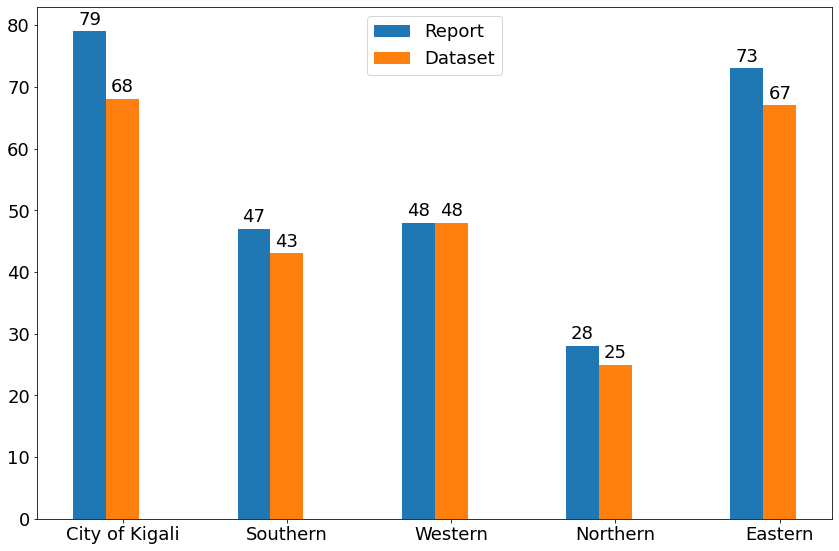

In [10]:
# We compare the distribution of the sample from the report

provinces = np.unique(main['Province'])
districts = np.unique(main['District'])
villages = np.unique(main['Village'])

report_df = pd.DataFrame.from_dict(
    {
        'Province':["City of Kigali","Southern","Western","Northern","Eastern"],
        'Villages':[79,47,48,28,73],
        'Households':[948,564,576,336,876], 
    })

n_villages = []
n_hh = []
for p in report_df['Province']:
    df_p = main.loc[main['Province']==p]
    villages = np.unique(df_p['Village'])
    n_villages.append(len(villages))
    n_hh.append(len(df_p))
    
real_df = pd.DataFrame.from_dict(
    {
        'Province':["City of Kigali","Southern","Western","Northern","Eastern"],
        'Villages': n_villages,
        'Households': n_households, 
    })  
    
bars_data = [
    {
        'label': "Report",
        'data': report_df['Villages']
    },
    {
        'label': "Dataset",
        'data': real_df['Villages']
    }
]


plot_bars(x_labels=real_df['Province'],bars_data=bars_data,length=12,height=8,add_autolabel=True,percent=False)


### Type of habitat

There are two questions related to the habitat in the main dataset:
- **B5**: "What is the type of habitat?". Answers 1-3 are considered **rural**, answers 4-6 are considered **urban**.
- Question **6** of the household identification section. However, the questionnaire has 2 options (urban, rural), while the dataset contains up to 6 possible answers



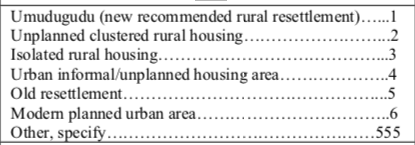

In [11]:
# Here is a screenshot of the questionnaire. 
Image("../references/rural_urban.png")

To always have the information about urban/rural, we add a new column to the main dataset:

In [13]:
# We add a new column to the main dataset, with values 'urban','rural', or 'other'
# First option habitat_question = "B5_What is the type of habitat"
habitat_question = "B5_What is the type of habitat"
habitat = []
for index,row in main.iterrows():
    if row[habitat_question]==4 or row[habitat_question]==5 or row[habitat_question]==6:
        habitat.append('urban')
    elif row[habitat_question]==1 or row[habitat_question]==2 or row[habitat_question]==3:
        habitat.append('rural')
    else:
        habitat.append('other')
        
##
main['habitat'] = habitat

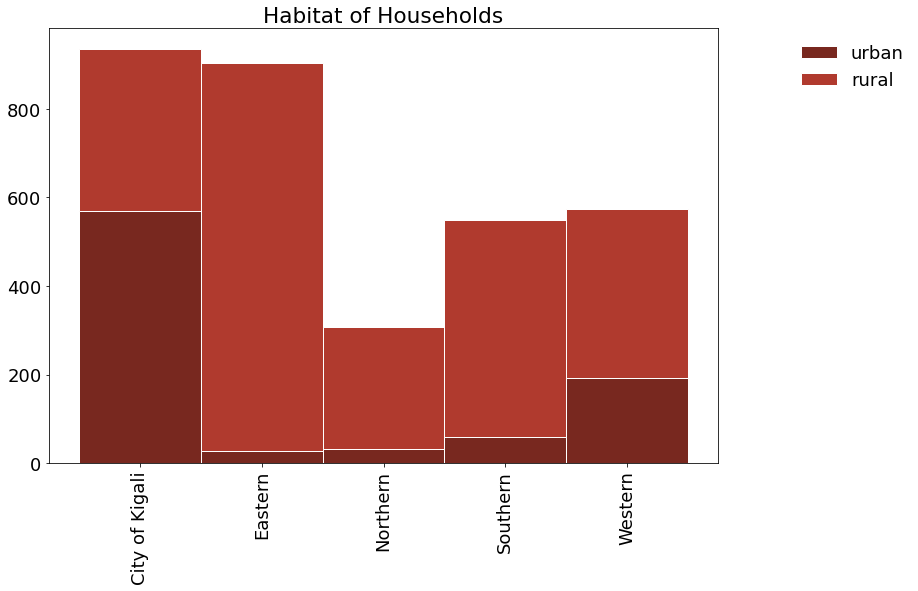

In [14]:
# We now check our overall habitat distribution

habitat = ["urban","rural"]
data = get_bar_chart_data(main,provinces,"Province",habitat,"habitat")
data["title"]="Habitat of Households"
stacked_bar_chart(data,color_scheme=VARIATION,barWidth=1,
                  figure_name=None,
                      with_legend=True,title=True,
                      horizontal=False,
                      filename_legend=None,
                      length=12,height=8) 

________________________________________________________________

## Access to electricity

The questions related to the access to electricity are in section C. 

Rwanda’s greatest challenge is to provide access to at least basic electricity supply (Tier
1 or above) to households without any access (Tier 0).

To improve access to electricity among grid-connected households, Rwanda needs to
improve Reliability, Quality, and Availability. 



### Main source of electricity

We consider the question **C.182: Of all the sources that you mentioned above, which is the source that you use most of the time in your household?**


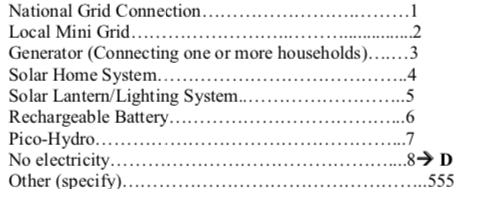

In [15]:
Image('../references/main_elec_source.png')

In [16]:
main_source_question = 'C182_which is the source that you use most of the time'
sources = [1,2,3,4,5,6,7,8,40,555]
sources_labels = ["National Grid","Local Mini Grid","Generator","Solar Home System",
                  "Solar Lantern/Lighting System", "Rechargeable Battery","Pico-Hydro",
                  "No electricity","(no data)","Other"]
data = get_bar_chart_data(main,provinces,"Province",sources,main_source_question)
data["title"]="Main source of electricity"
data['bars_labels'] = sources_labels

# Note: maybe we should remove all HH with "Other", "NA", and "40", 
# as these answer does not help in the following analysis

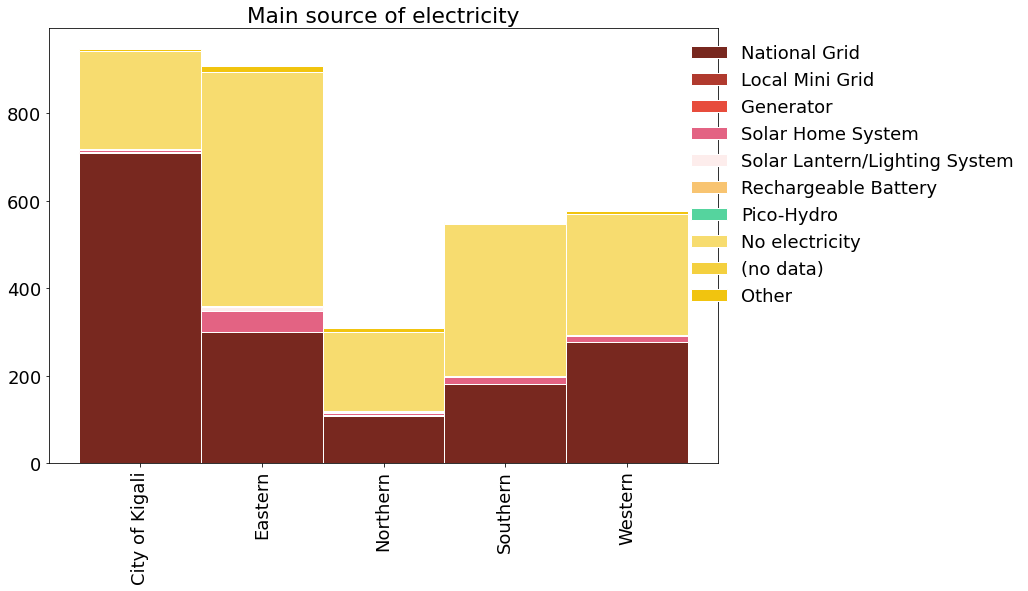

In [17]:
stacked_bar_chart(data,color_scheme=VARIATION,barWidth=1,
                  figure_name=None,
                      with_legend=True,title=True,
                     horizontal=False,
                      filename_legend=None,
                     length=12,height=8) 

### Connection to the national grid

**In the questionaire:**

C.2: Is the household connected to the national grid?

In [18]:
# Data section C2

# Enter the question for the access to the national grid 
question_grid = 'C2_household connected to the national grid'

data_C2 = main[['Household Identification', question_grid, 'habitat']]


In [19]:
# 1 = Yes, 2= No 
access_grid = len(data_C2[data_C2[question_grid] == 1])
no_access_grid = len(data_C2[data_C2[question_grid] == 2]) 
percent = [100*access_grid/n_households,100*no_access_grid/n_households]

## Access to modern cooking solutions

The questions related to the access to modern cooking solutions are in the section I of the quesitonaire. 

The main challeng is to provide all households access to cooking solutions that are clean, efficient, convinient, affordable, safe and available. 

In Rwanda, a high percentage of households still use highly polluting stoves, and a very low percentage use clean fuel.

### Health and Safety 

For this section, we are focusing on safety and health related  to the questions I31_(1 to 8).

In the case of Rwanda, three different categories are considered:
- Major injury (death, permanent health damage, burns/fire/poisoning, severe cough or respiratory problem)
- Minor injury (e.g., watery eyes)
- No accidents

Households where major injury has occurred are ranked in **Tier 3**, otherwise in **Tier 5**.

The question for the evaluation of the Tier is **I31**: "In the last 12 months, what type of harm/injury did your household face from this cookstove?"

**Remark**[Naomi] In the report, it seems that the World consideres only injuries from the **primary** cookstove. One should check how to get this out of the data

--> I.3 : In the last 12 months, which cookstove did your household use for preparing meals (up to 5 listed).


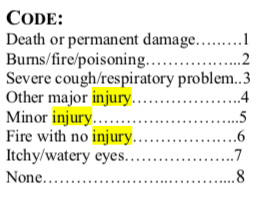

In [20]:

# Here is a screenshot of the questionnaire. 
Image("../references/cooking_injuries.png")

There are therefore 8 options for this (multiple choice) question, which are coded as I31_1, ...,I31_8 in the database. Let us create a list of labels for this.

In [21]:
# Type of harm/injuries in the table
safety_questions_code = ['I31_'+str(k) for k in range(1,9)]


In [22]:
# Note: we can get the total number of answers per categoty from the 'codebook'
choices_id = []
choices_count = []
choices_label = []
for index,row in codebook_I.iterrows():
    if 'I31' in row['Variable']:
        choices_id.append(int(row['Variable'].replace('I31_','')))
        choices_count.append(row['Obs'])
        choices_label.append(row['Label'].replace(row['Variable']+'_',''))

total = sum(choices_count)
print("Statistics according to cookstoves ")
for l in range(0,len(choices_label)):
    print(choices_label[l]," = ",choices_count[l]," (", round(choices_count[l]/total*100,2),"%)")



Statistics according to cookstoves 
Death or permanent damage  =  1  ( 0.03 %)
Burns/fire/poisoning  =  45  ( 1.24 %)
Severe cough/respiratory problem  =  29  ( 0.8 %)
Other major injury  =  8  ( 0.22 %)
Minor injury  =  78  ( 2.14 %)
Fire with no injury  =  25  ( 0.69 %)
Itchy/watery eyes  =  5  ( 0.14 %)
None  =  3447  ( 94.75 %)


**Remark**: To get the data **per household** we have to go throught the database using the HHID key

In [23]:
# Check the number of household
n_household = len(np.unique(section_I["HHID"]))
section_I_HHID = section_I.groupby(['HHID']).sum()

# Let's add the type of habitat to the section I so we can separate according to rural/Urban info. 
injuries_df = pd.DataFrame.from_dict({'habitat': main['habitat'],'HHID': np.unique(section_I["HHID"])})
injuries_df
for i in safety_questions_code:
    injuries_df[i] = np.array(section_I_HHID[i])

    
injuries_df   

,habitat,HHID,I31_1,I31_2,I31_3,I31_4,I31_5,I31_6,I31_7,I31_8
0,urban,1102020811001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,urban,1102020811002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,urban,1102020811003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
3,urban,1102020811004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,urban,1102020811005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...
3290,rural,5714040157078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3291,rural,5714040157079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3292,rural,5714040157082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3293,rural,5714040157083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [24]:

# now we can calculate the results for total sample, urban and rural habitat using the same function
total_injuries = get_multiple_choice_values(injuries_df,safety_questions_code)
urban_injuries = get_multiple_choice_values(injuries_df.loc[injuries_df['habitat']=='urban'],safety_questions_code)
rural_injuries = get_multiple_choice_values(injuries_df.loc[injuries_df['habitat']=='rural'],safety_questions_code)

print('total',total_injuries)
print('urban',urban_injuries)
print('rural',rural_injuries)


total {'major_accident': 2.4582701062215477, 'minor_accident': 3.1866464339908953, 'no_accident': 93.71775417298937}
urban {'major_accident': 1.4722536806342015, 'minor_accident': 1.1325028312570782, 'no_accident': 96.82899207248018}
rural {'major_accident': 2.682313495389774, 'minor_accident': 3.93964794635373, 'no_accident': 92.62363788767813}


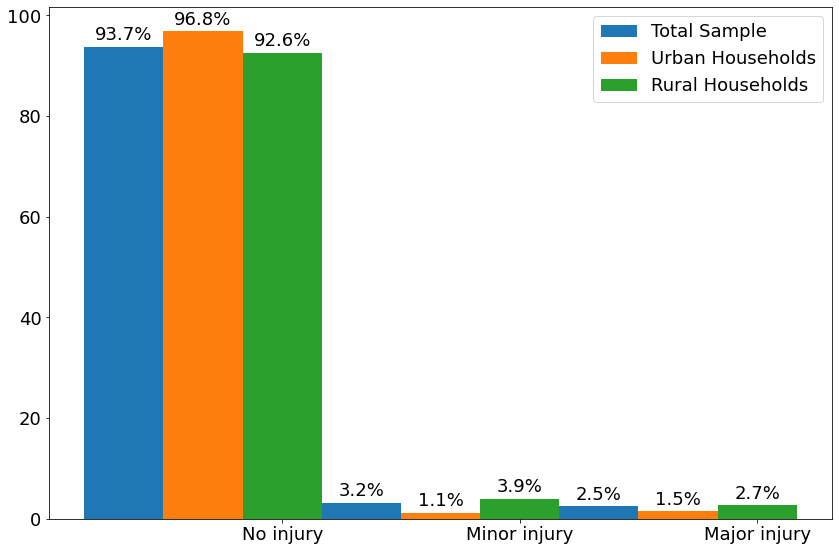

In [25]:
# grouped bar chart
x_labels = ['No injury','Minor injury','Major injury']
bars_data = [
    {
        'label': 'Total Sample',
        'data': [total_injuries['no_accident'],total_injuries['minor_accident'],total_injuries['major_accident']]
    },
    {
        'label': 'Urban Households',
        'data': [urban_injuries['no_accident'],urban_injuries['minor_accident'],urban_injuries['major_accident']]
    },
    {
        'label': 'Rural Households',
        'data': [rural_injuries['no_accident'],rural_injuries['minor_accident'],rural_injuries['major_accident']]
    },
    
    
]

plot_bars(x_labels,bars_data,length=12,height=8,add_autolabel=True)



<AxesSubplot:title={'center':'Proportion of total accident'}>

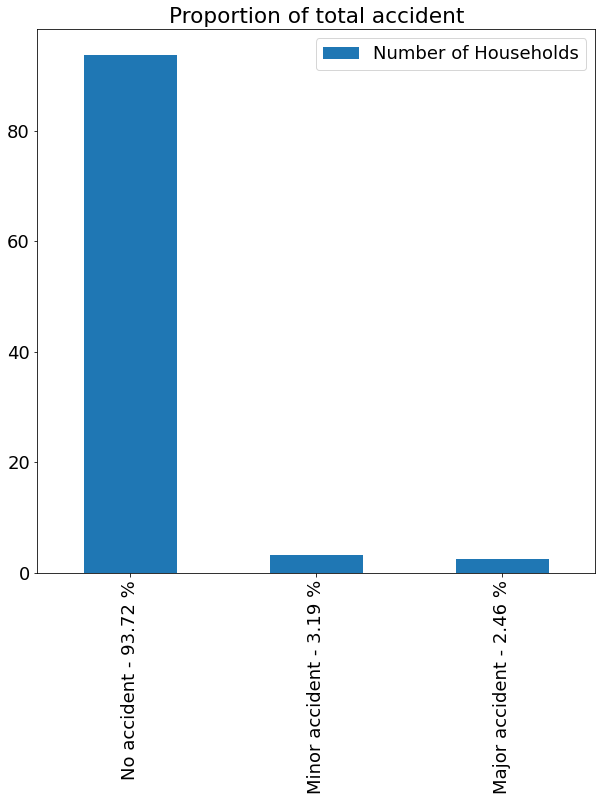

In [46]:
percent = [total_injuries['no_accident'], total_injuries['minor_accident'],total_injuries['major_accident']] 
index = ['No accident', 'Minor accident', 'Major accident']
pie_ = pd.DataFrame({'Number of Households': percent},
                  index = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(index, percent)])

pie_.plot.bar(y ='Number of Households', figsize=(10, 10), title = 'Proportion of total accident')


### Results 
- 2.5% of households are ranked in Safety Tier 3 (in the Rwanda Report: 2.2%)
- 97.5% of households are ranked in Safety Tier 5

#### Per Habitat:
- MTF urban Tier 3 : 1.2% - here: 1.48%
- MTF rural Tier 3 : 2.1% - here: 2.70%


____________________________________

## Access to electricity

The questions related to the access to electricity are in section C. 

Rwanda’s greatest challenge is to provide access to at least basic electricity supply (Tier
1 or above) to households without any access (Tier 0).

To improve access to electricity among grid-connected households, Rwanda needs to
improve Reliability, Quality, and Availability. 

### Type of electricity


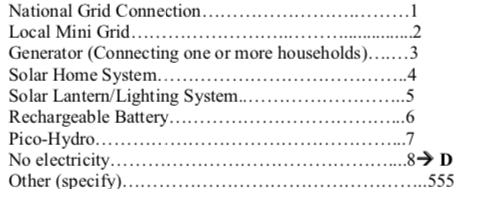

In [27]:
Image('../references/main_elec_source.png')

#### Connection to the national grid

**In the questionaire:**

C.2: Is the household connected to the national grid?


In [47]:
# Data section C2

# Enter the question for the access to the national grid 
question_grid = 'C2_household connected to the national grid'

data_C2 = main[['Household Identification', question_grid, 'habitat']]



##### Nationwide access to the grid:

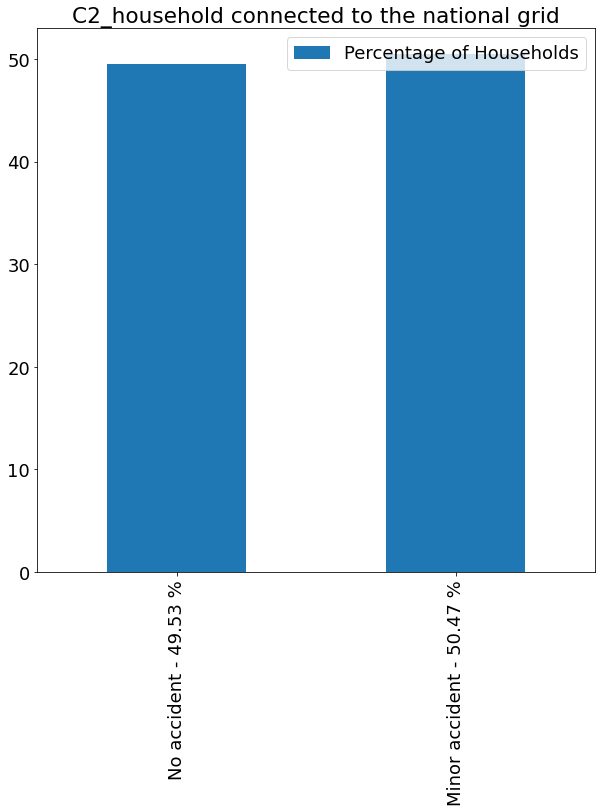

In [48]:
# 1 = Yes, 2= No 
access_grid = len(data_C2[data_C2[question_grid] == 1])
no_access_grid = len(data_C2[data_C2[question_grid] == 2]) 

percent = [100*access_grid/n_households,100*no_access_grid/n_households]

simple_bar_plot(index,'Percentage of Households',percent,question_grid)

### Reasons Households Not Connected To Grid

For a cross-check, we look at the question **C3_MAIN reason why your household is not connected to the grid**

In [41]:
q = "C3_MAIN reason why your household is not connected to the grid"
not_connected = main.loc[main[question_grid]==2]
not_connected.head()
reason = not_connected[q]

N = len(not_connected)
not_connected[q].head()
count = []
for k in range(0,9):
    count.append(0.)
    
for index,row in not_connected.iterrows():
    for k in range(1,10):
        if not np.isnan(row[q]) and int(row[q])==k:
            count[k-1] += 1

not_na = sum(count)
for k in range(0,9):
    count[k] = round(count[k]/not_na,3)*100
        
    
count


[35.0, 53.6, 1.2, 0.1, 5.7, 0.0, 0.2, 3.6999999999999997, 0.5]

**According to the MTF report:**

23.5% of households have access through the grid, and 5.1% have access through off-grid solutions, mostly solar. 


**Here:**

We have very different results here: almost the hald have access to the national grid. 


##### Rural/Urban access to the grid:

In [49]:
# Separation of rural/urban in the dataset
rural_C2 = data_C2[data_C2['habitat'] == 'rural']
urban_C2 = data_C2[data_C2['habitat'] == 'urban']


# Urban access to the grid
urban_access_grid = len(urban_C2[urban_C2[question_grid] == 1])
urban_no_access_grid = len(urban_C2[urban_C2[question_grid] == 2]) 

urban_percent = [100*urban_access_grid/len(urban_C2),100*urban_no_access_grid/len(urban_C2)]


# Rural access to the grid
rural_access_grid = len(rural_C2[rural_C2[question_grid] == 1])
rural_no_access_grid = len(rural_C2[rural_C2[question_grid] == 2]) 

rural_percent = [100*rural_access_grid/len(rural_C2),100*rural_no_access_grid/len(rural_C2)]



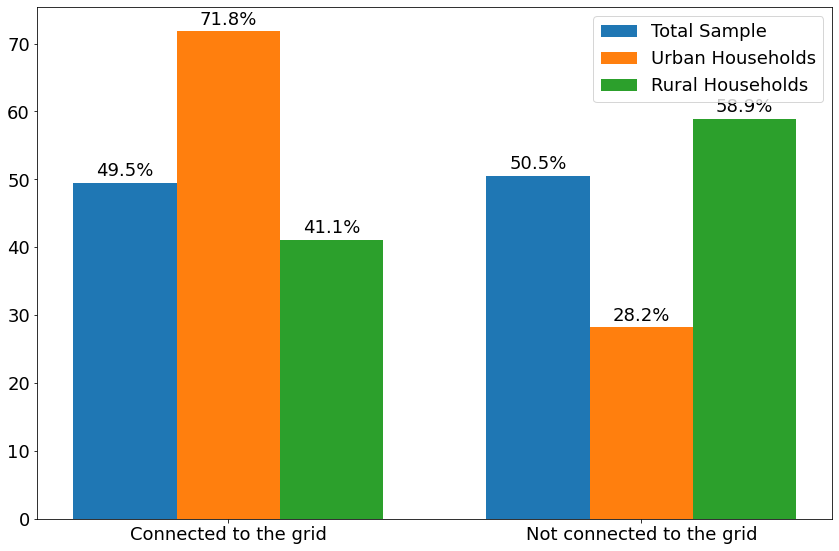

In [50]:
# grouped bar chart
labels = ['Connected to the grid','Not connected to the grid']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width, percent, width, label='Total Sample')
rects2 = ax.bar(x, urban_percent, width, label='Urban Households')
rects3 = ax.bar(x + width, rural_percent, width, label='Rural Households')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

**According to the MTF report**


77.4% of urban households are connected to the grid, compared with 15.6% of rural households.

**Here**


71.8% of urban households are connected to the grid, compared with 41.1% of rural households. 

### Security of electricity 

Check if among the different type of electricity, some injuries/damages occured.

The general question is:

"In the last 12 months, did any household members die or have permanent limb (bodily injury) damage because of the electricity ?"


### Availability of Electricity

Check if the amount of electricity available for each type of electricity.


The general questions are: 

"How many hours of electricity are available each day and night from the grid? (max 24 hours)"


"How many hours of electricity are available
each evening, from 6:00 pm to 10:00 pm from the grid?(max 4 hours)"

##### Type of electicity  and its related security question:

- 1- Electricity from National Grid C41
- 2- Electricity from Mini Grid C83
- 3- Electric geneator set C112
- 4- Rechargeable Battery C130
- 5- Pico-Hydro C142
- 6- Solar device C175


* 7- Lamp/Candle (with fuel and not electricity) ? In the last 12 months, what type of harm/injury did any household members have from [LAMP/ CANDLE]? F14

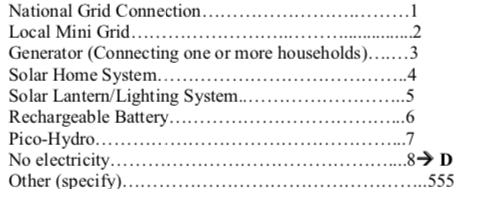

In [91]:
Image('../references/main_elec_source.png')

##### Tier computation

We will try here to evaluate the proportion of tier 3 and 5, regarding the injuries/damages question.

We will refer to the table of the MTF report related to access to electricity (screenshot bellow).


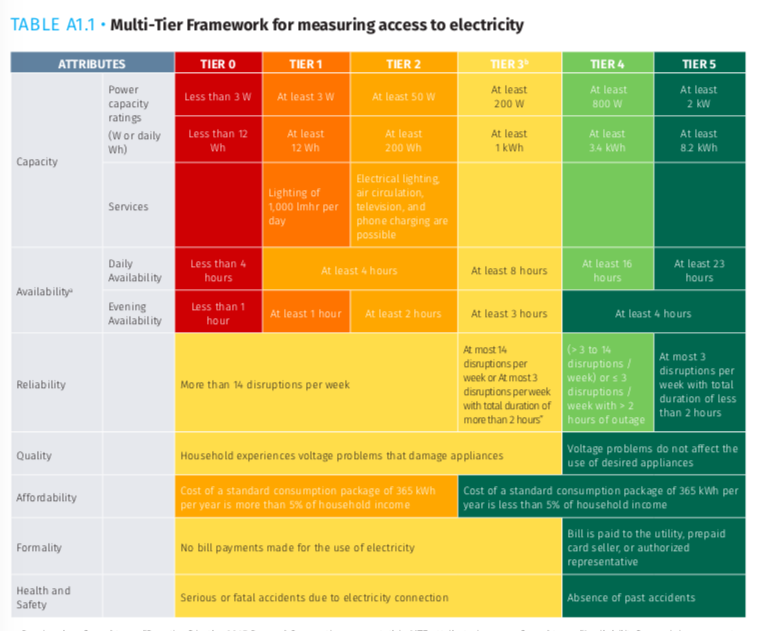

In [84]:
Image('../references/MTF_energy_access.png')

In [51]:
# Questions related to availability during a typical month

# Availability during the whole day
question_avail_allday_national_grid =  'C26b_hours of electricity availability each day and night (Typical Months)'
question_avail_allday_grid = 'C68b_hours of electricity availability each day and night (Typical Months)'
question_avail_allday_gene = 'C107b_hours could you use this generator each day and night  (Typical Months)'
question_avail_allday_bat = 'C127_hours  you could use rechargeable batteries for electricity supply each day'
question_avail_allday_pico ='C137b_hours you could use this pico-hydro system each day and night (Typical Months)'
question_avail_allday_solar = 'C172b_hours you receive service from this DEVICE each day and night (Typical Months)'


# Availability during the evening
question_avail_evening_national_grid =  'C27b_hours electricity is available each evening (Typical Month)'
question_avail_evening_grid = 'C69b_hours of electricity availability each evening (Typical Months)'
question_avail_evening_gene = 'C108b_hours could you use this generator each evening (Typical Months)'
question_avail_evening_pico ='C138b_hours you could use this pico-hydro system each evening (Typical Months)'
question_avail_evening_solar = 'C173b_C173a_hours is service available from this DEVICE each evening (Typical Months)'


In [55]:
# Question related to safety/ injuries/damages during a typical month 

question_injury_national_grid =  'C41_household member died or damaged because of electricity'
question_injury_mini_grid = 'C83_household members die or injured because of the grid electricity'
question_injury_gene = 'C112_household members died or injured because of the generator'
question_injury_bat = 'C130_household members died  injured because of the rechargeable batteries'
question_injury_pico ='C142_household members died injured because of the pico-hydro system'
question_injury_solar = 'C175_household members died or  injured because of the DEVICE'



In [56]:
E_safety_tier = []
E_Availability_tier_daily = []
E_Availability_tier_evening = []

for index,row in main.iterrows():
    if row[main_source_question]==1:
        
        if row[question_injury_national_grid]==1:
            E_safety_tier.append(3)
        elif row[question_injury_national_grid]==2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
            
        
        if row[question_avail_allday_national_grid] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_national_grid] >= 4 and row[question_avail_allday_national_grid] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_national_grid] >= 8 and row[question_avail_allday_national_grid] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_national_grid] >= 16 and row[question_avail_allday_national_grid] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_national_grid] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
            
        if row[question_avail_evening_national_grid] < 1:
            E_Availability_tier_evening.append(0)
        elif row[question_avail_evening_national_grid] >= 1 and row[question_avail_evening_national_grid] < 2:
            E_Availability_tier_evening.append(1)
        elif row[question_avail_evening_national_grid] >= 2 and row[question_avail_evening_national_grid] < 3:
            E_Availability_tier_evening.append(2)
        elif row[question_avail_evening_national_grid] >= 3 and row[question_avail_evening_national_grid] < 4:
            E_Availability_tier_evening.append(3)
        elif row[question_avail_evening_national_grid] >= 4:
            E_Availability_tier_evening.append(5)
        else:
            E_Availability_tier_evening.append(np.nan)
            
                   
    elif row[main_source_question] == 2:
        if row[question_injury_mini_grid] == 1:
            E_safety_tier.append(3)
        elif row[question_injury_mini_grid] == 2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
                  
        if row[question_avail_allday_grid] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_grid] >= 4 and row[question_avail_allday_grid] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_grid] >= 8 and row[question_avail_allday_grid] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_grid] >= 16 and row[question_avail_allday_grid] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_grid] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
            
        if row[question_avail_evening_grid] < 1:
            E_Availability_tier_evening.append(0)
        elif row[question_avail_evening_grid] >= 1 and row[question_avail_evening_grid] < 2:
            E_Availability_tier_evening.append(1)
        elif row[question_avail_evening_grid] >= 2 and row[question_avail_evening_grid] < 3:
            E_Availability_tier_evening.append(2)
        elif row[question_avail_evening_grid] >= 3 and row[question_avail_evening_grid] < 4:
            E_Availability_tier_evening.append(3)
        elif row[question_avail_evening_grid] >= 4:
            E_Availability_tier_evening.append(5)
        else:
            E_Availability_tier_evening.append(np.nan)     
        
    elif row[main_source_question] == 3:
        if row[question_injury_gene] == 1:
            E_safety_tier.append(3)
        elif row[question_injury_gene] == 2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
            
        if row[question_avail_allday_gene] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_gene] >= 4 and row[question_avail_allday_gene] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_gene] >= 8 and row[question_avail_allday_gene] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_gene] >= 16 and row[question_avail_allday_gene] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_gene] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
            
        if row[question_avail_evening_gene] < 1:
            E_Availability_tier_evening.append(0)
        elif row[question_avail_evening_gene] >= 1 and row[question_avail_evening_gene] < 2:
            E_Availability_tier_evening.append(1)
        elif row[question_avail_evening_gene] >= 2 and row[question_avail_evening_gene] < 3:
            E_Availability_tier_evening.append(2)
        elif row[question_avail_evening_gene] >= 3 and row[question_avail_evening_gene] < 4:
            E_Availability_tier_evening.append(3)
        elif row[question_avail_evening_gene] >= 4:
            E_Availability_tier_evening.append(5)
        else:
            E_Availability_tier_evening.append(np.nan)
            
            
    elif row[main_source_question] == 4 or row[main_source_question] == 5:
        
        if row[question_injury_solar] == 1:
            E_safety_tier.append(3)
        elif row[question_injury_solar] == 2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
            
        if row[question_avail_allday_solar] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_solar] >= 4 and row[question_avail_allday_solar] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_solar] >= 8 and row[question_avail_allday_solar] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_solar] >= 16 and row[question_avail_allday_solar] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_solar] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
            
        if row[question_avail_evening_solar] < 1:
            E_Availability_tier_evening.append(0)
        elif row[question_avail_evening_solar] >= 1 and row[question_avail_evening_solar] < 2:
            E_Availability_tier_evening.append(1)
        elif row[question_avail_evening_solar] >= 2 and row[question_avail_evening_solar] < 3:
            E_Availability_tier_evening.append(2)
        elif row[question_avail_evening_solar] >= 3 and row[question_avail_evening_solar] < 4:
            E_Availability_tier_evening.append(3)
        elif row[question_avail_evening_solar] >= 4:
            E_Availability_tier_evening.append(5)
        else:
            E_Availability_tier_evening.append(np.nan)
    
    elif row[main_source_question] == 6:
        if row[question_injury_bat] == 1:
            E_safety_tier.append(3)
        elif row[question_injury_bat]==2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
            
        if row[question_avail_allday_bat] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_bat] >= 4 and row[question_avail_allday_bat] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_bat] >= 8 and row[question_avail_allday_bat] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_bat] >= 16 and row[question_avail_allday_bat] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_bat] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
    
        E_Availability_tier_evening.append(np.nan)
                    
        
    elif row[main_source_question]==7:
        if row[question_injury_pico]==1:
            E_safety_tier.append(3)
        elif row[question_injury_pico]==2:
            E_safety_tier.append(5)
        else:
            E_safety_tier.append(np.nan)
        
        if row[question_avail_allday_pico] < 4:
            E_Availability_tier_daily.append(0)
        elif row[question_avail_allday_pico] >= 4 and row[question_avail_allday_pico] < 8:
            E_Availability_tier_daily.append(2)
        elif row[question_avail_allday_pico] >= 8 and row[question_avail_allday_pico] < 16:
            E_Availability_tier_daily.append(3)
        elif row[question_avail_allday_pico] >= 16 and row[question_avail_allday_pico] < 23:
            E_Availability_tier_daily.append(4)
        elif row[question_avail_allday_pico] >= 23:
            E_Availability_tier_daily.append(5)
        else:
            E_Availability_tier_daily.append(np.nan)
            
            
        if row[question_avail_evening_pico] < 1:
            E_Availability_tier_evening.append(0)
        elif row[question_avail_evening_pico] >= 1 and row[question_avail_evening_pico] < 2:
            E_Availability_tier_evening.append(1)
        elif row[question_avail_evening_pico] >= 2 and row[question_avail_evening_pico] < 3:
            E_Availability_tier_evening.append(2)
        elif row[question_avail_evening_pico] >= 3 and row[question_avail_evening_pico] < 4:
            E_Availability_tier_evening.append(3)
        elif row[question_avail_evening_pico] >= 4:
            E_Availability_tier_evening.append(5)
        else:
            E_Availability_tier_evening.append(np.nan)
            
    else:
        E_safety_tier.append(np.nan)
        E_Availability_tier_evening.append(np.nan)
        E_Availability_tier_daily.append(np.nan)
        
        
main['E_Safety'] = E_safety_tier
main['E_daily_Availability'] = E_Availability_tier_daily 
main['E_evening_Availability'] = E_Availability_tier_evening


In [57]:
# Plot percentage of Tier 3 and Tier 5 in terms of health and security. 

n_tier3 = E_safety_tier.count(3)
n_tier5 = E_safety_tier.count(5)
n_tot = n_tier3 + n_tier5

rural_tier = main[main['habitat'] == 'rural']
urban_tier = main[main['habitat'] == 'urban']

# Urban access to the grid
urban_tier3 = len(urban_tier[urban_tier['E_Safety'] == 3])
urban_tier5 = len(urban_tier[urban_tier['E_Safety'] == 5]) 

n_tot_urb = len(urban_tier[urban_tier['E_Safety'] == 3]) + len(urban_tier[urban_tier['E_Safety'] == 5]) 


# Rural access to the grid
rural_tier3 = len(rural_tier[rural_tier['E_Safety'] == 3])
rural_tier5 = len(rural_tier[rural_tier['E_Safety'] == 5]) 

n_tot_rur = len(rural_tier[rural_tier['E_Safety'] == 3]) + len(rural_tier[rural_tier['E_Safety'] == 5]) 


urban_percent = [100*urban_tier3/n_tot_urb,100*urban_tier5/n_tot_urb]
rural_percent = [100*rural_tier3/n_tot_rur,100*rural_tier5/n_tot_rur]



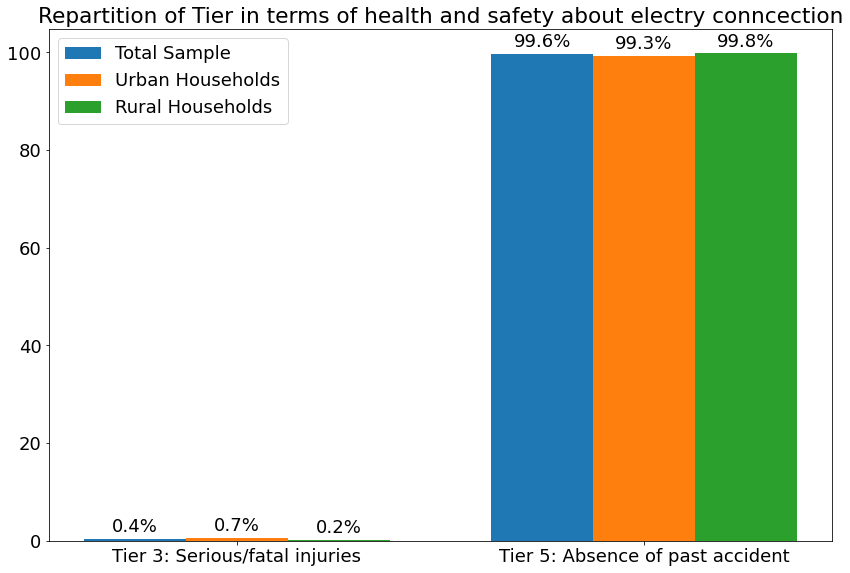

In [58]:
# grouped bar chart
labels = ['Tier 3: Serious/fatal injuries', 'Tier 5: Absence of past accident']

percent = [100*n_tier3/n_tot, 100*n_tier5/n_tot]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width, percent, width, label='Total Sample')
rects2 = ax.bar(x, urban_percent, width, label='Urban Households')
rects3 = ax.bar(x + width, rural_percent, width, label='Rural Households')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Repartition of Tier in terms of health and safety about electry conncection')
plt.show()

In [59]:
# Plot percentage of tier in terms of availability 

n_tier_daily0 = E_Availability_tier_daily.count(0)
n_tier_daily2 = E_Availability_tier_daily.count(2)
n_tier_daily3 = E_Availability_tier_daily.count(3)
n_tier_daily4 = E_Availability_tier_daily.count(4)
n_tier_daily5 = E_Availability_tier_daily.count(5)


n_tot = n_tier_daily0 + n_tier_daily2 + n_tier_daily3 + n_tier_daily4 + n_tier_daily5

percent = [100*n_tier_daily0/n_tot,100*n_tier_daily2/n_tot,100*n_tier_daily3/n_tot,100*n_tier_daily4/n_tot,100*n_tier_daily5/n_tot]

rural_tier = main[main['habitat'] == 'rural']
urban_tier = main[main['habitat'] == 'urban']

# Urban access to the grid
urban_tier0 = len(urban_tier[urban_tier['E_daily_Availability'] == 0])
urban_tier2 = len(urban_tier[urban_tier['E_daily_Availability'] == 2])
urban_tier3 = len(urban_tier[urban_tier['E_daily_Availability'] == 3])
urban_tier4 = len(urban_tier[urban_tier['E_daily_Availability'] == 4]) 
urban_tier5 = len(urban_tier[urban_tier['E_daily_Availability'] == 5]) 

n_tot_urb = urban_tier0+urban_tier2+urban_tier3+urban_tier4+urban_tier5


# Rural access to the grid
rural_tier0 = len(rural_tier[rural_tier['E_daily_Availability'] == 0])
rural_tier2 = len(rural_tier[rural_tier['E_daily_Availability'] == 2]) 
rural_tier3 = len(rural_tier[rural_tier['E_daily_Availability'] == 3])
rural_tier4 = len(rural_tier[rural_tier['E_daily_Availability'] == 4]) 
rural_tier5 = len(rural_tier[rural_tier['E_daily_Availability'] == 5]) 

n_tot_rur = rural_tier0 + rural_tier2 + rural_tier3 + rural_tier4 + rural_tier5


urban_percent = [100*urban_tier0/n_tot_urb,100*urban_tier2/n_tot_urb,100*urban_tier3/n_tot_urb,100*urban_tier4/n_tot_urb,100*urban_tier5/n_tot_urb]
rural_percent = [100*rural_tier0/n_tot_rur,100*rural_tier2/n_tot_rur,100*rural_tier3/n_tot_rur,100*rural_tier4/n_tot_rur,100*rural_tier5/n_tot_rur]



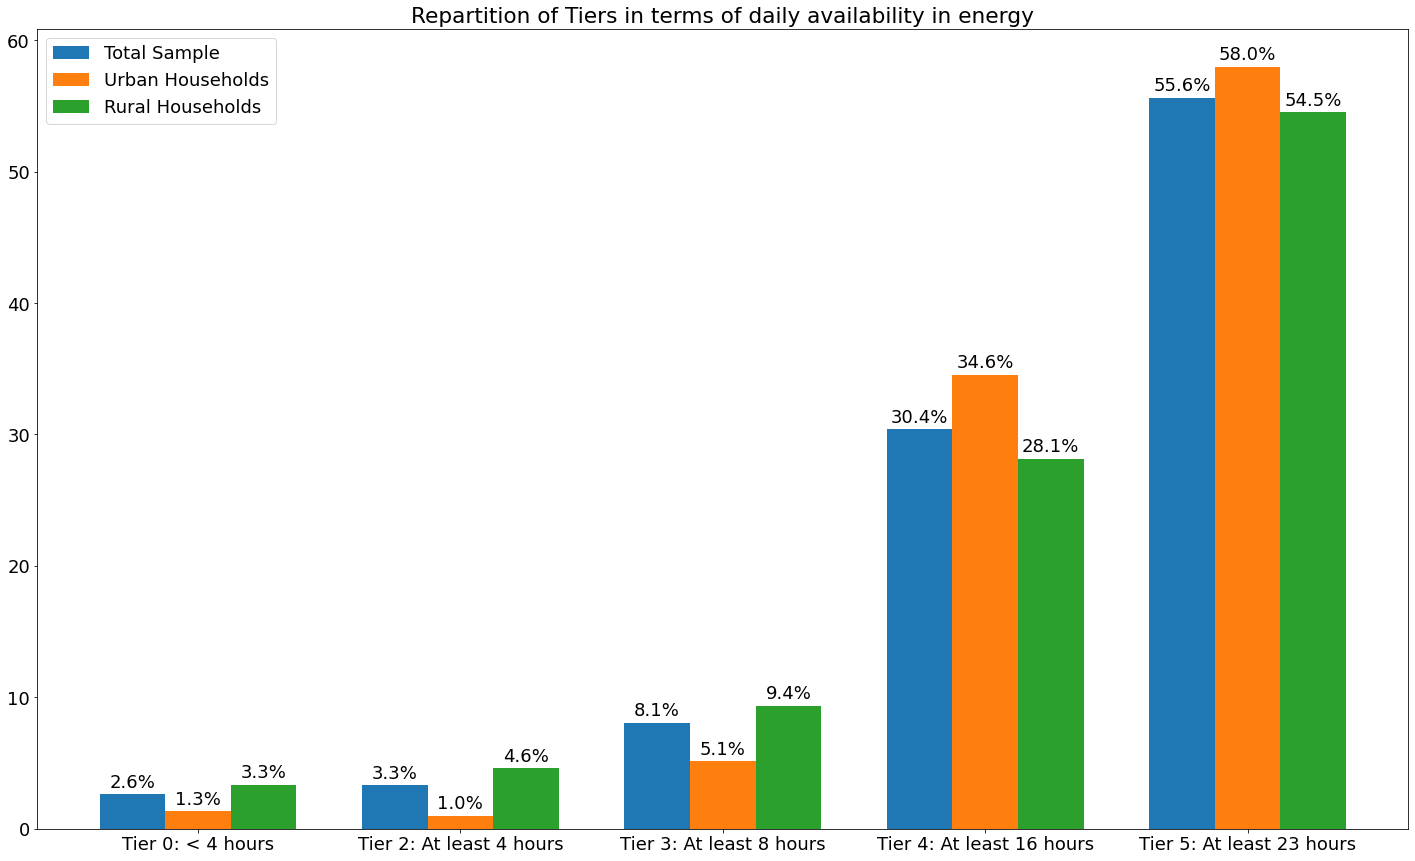

In [60]:
# grouped bar chart
labels = ['Tier 0: < 4 hours', 'Tier 2: At least 4 hours', 'Tier 3: At least 8 hours', 'Tier 4: At least 16 hours','Tier 5: At least 23 hours' ]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x - width, percent, width, label = 'Total Sample')
rects2 = ax.bar(x, urban_percent, width, label = 'Urban Households')
rects3 = ax.bar(x + width, rural_percent, width, label = 'Rural Households')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Repartition of Tiers in terms of daily availability in energy')
plt.show()

### Results/Comments:

The results are quite closed to the MTF report:

For example Nationwide: 

**MTF report:**


5.9% - 7.0% - 10.1%- 27.5 % - 49.6%

**Here:**

2.6% - 3.3% - 8.1% - 30.4% - 55.6%


For example Urban: 

**MTF report:**

1.4% - 2.7% - 8.4.1%- 30.7 % - 56.8%

**Here:**

1.3% - 1.0% - 5.1% - 34.6% - 58.0%




In [61]:
# Plot percentage of tier in terms of availability 

n_tier_daily0 = E_Availability_tier_evening.count(0)
n_tier_daily1 = E_Availability_tier_evening.count(1)
n_tier_daily2 = E_Availability_tier_evening.count(2)
n_tier_daily3 = E_Availability_tier_evening.count(3)
n_tier_daily5 = E_Availability_tier_evening.count(5)


n_tot = n_tier_daily0 + n_tier_daily2 + n_tier_daily3 + n_tier_daily1 + n_tier_daily5

percent = [100*n_tier_daily1/n_tot,100*n_tier_daily2/n_tot,100*n_tier_daily3/n_tot,100*n_tier_daily5/n_tot]

rural_tier = main[main['habitat'] == 'rural']
urban_tier = main[main['habitat'] == 'urban']

# Urban access to the grid
urban_tier0 = len(urban_tier[urban_tier['E_evening_Availability'] == 0])
urban_tier2 = len(urban_tier[urban_tier['E_evening_Availability'] == 2])
urban_tier3 = len(urban_tier[urban_tier['E_evening_Availability'] == 3])
urban_tier1 = len(urban_tier[urban_tier['E_evening_Availability'] == 1]) 
urban_tier5 = len(urban_tier[urban_tier['E_evening_Availability'] == 5]) 

n_tot_urb = urban_tier0+urban_tier2+urban_tier3+ urban_tier1 +urban_tier5


# Rural access to the grid
rural_tier0 = len(rural_tier[rural_tier['E_evening_Availability'] == 0])
rural_tier2 = len(rural_tier[rural_tier['E_evening_Availability'] == 2]) 
rural_tier3 = len(rural_tier[rural_tier['E_evening_Availability'] == 3])
rural_tier1 = len(rural_tier[rural_tier['E_evening_Availability'] == 1]) 
rural_tier5 = len(rural_tier[rural_tier['E_evening_Availability'] == 5]) 

n_tot_rur = rural_tier0 + rural_tier2 + rural_tier3 + rural_tier1 + rural_tier5


urban_percent = [100*urban_tier1/n_tot_urb,100*urban_tier2/n_tot_urb,100*urban_tier3/n_tot_urb,100*urban_tier5/n_tot_urb]
rural_percent = [100*rural_tier1/n_tot_rur,100*rural_tier2/n_tot_rur,100*rural_tier3/n_tot_rur,100*rural_tier5/n_tot_rur]


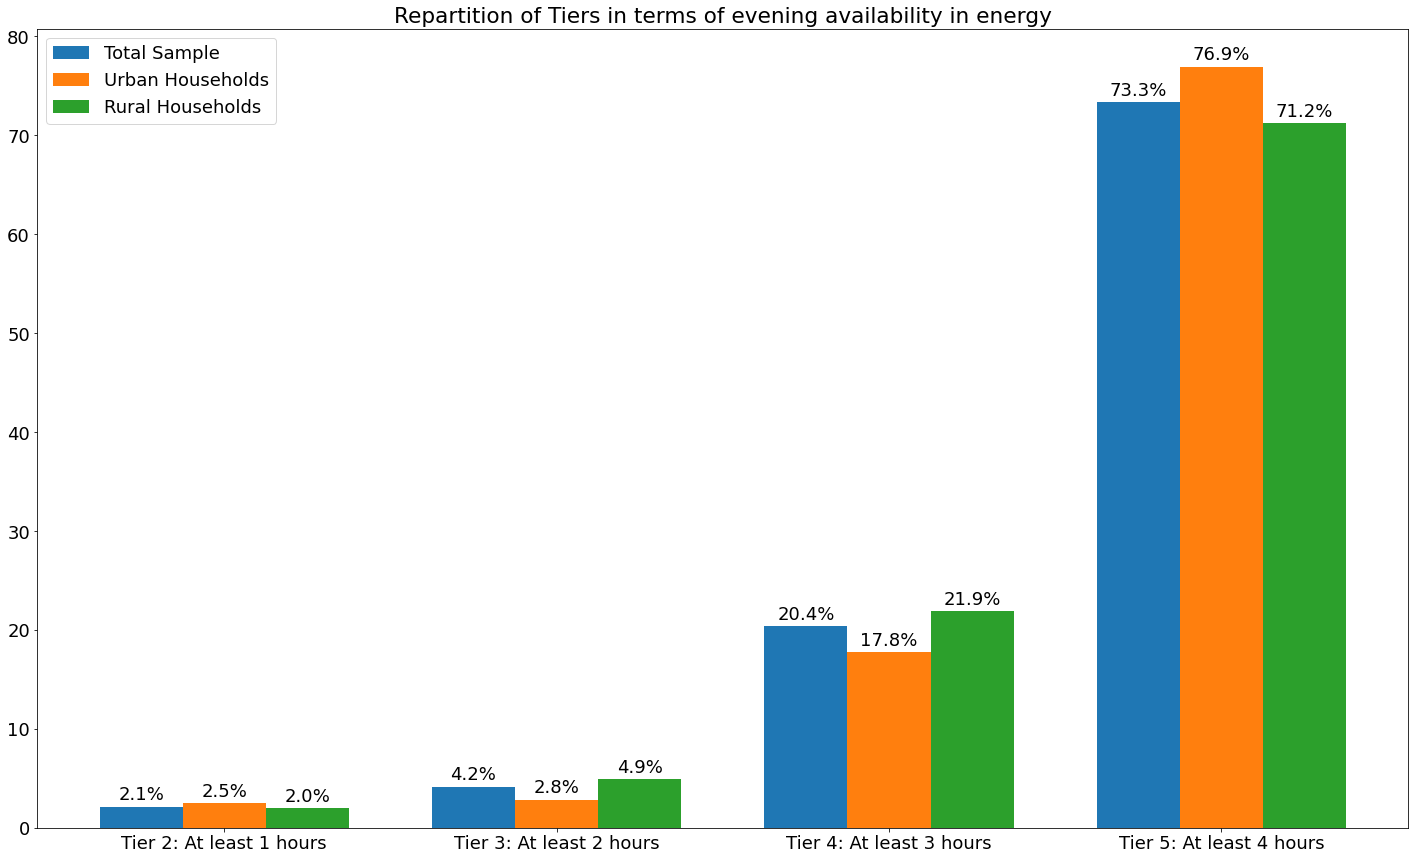

In [62]:
# grouped bar chart
labels = ['Tier 2: At least 1 hours', 'Tier 3: At least 2 hours', 'Tier 4: At least 3 hours','Tier 5: At least 4 hours' ]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x - width, percent, width, label='Total Sample')
rects2 = ax.bar(x, urban_percent, width, label='Urban Households')
rects3 = ax.bar(x + width, rural_percent, width, label='Rural Households')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Repartition of Tiers in terms of evening availability in energy')
plt.show()

### Results/Comments:

The results are quite closed to the MTF report:

NB: We didn't plit tier 0 because the %age is to 0 for the 3 cases

For example Nationwide: 

**MTF report:**


3.1% - 3.7% - 21.3%- 71.9 % 

**Here:**

2.1% - 4.2% - 20.4% - 73.3% 


For example Urban: 

**MTF report:**

1.2% - 2.1% - 20.7 % - 76.0%

**Here:**

2.5% - 2.8% - 17.8% - 76.9%



# Type of Electricity 

In [63]:
data_C182 = main[['Household Identification', main_source_question, 'habitat']]

data_C182

,Household Identification,C182_which is the source that you use most of the time,habitat
0,1102020811001,1.0,urban
1,1102020811002,8.0,urban
2,1102020811003,8.0,urban
3,1102020811004,8.0,urban
4,1102020811005,8.0,urban
...,...,...,...
3290,5714040157078,5.0,rural
3291,5714040157079,1.0,rural
3292,5714040157082,1.0,rural
3293,5714040157083,4.0,rural


In [64]:
# Nationwide 
n_nat_grid = len(data_C182[data_C182[question_main_source] == 1.0])
n_min_grid = len(data_C182[data_C182[question_main_source] == 2.0])
n_gene = len(data_C182[data_C182[question_main_source] == 3.0])
n_solar_home = len(data_C182[data_C182[question_main_source] == 4.0])
n_solar_lantern = len(data_C182[data_C182[question_main_source] == 5.0])
n_bat = len(data_C182[data_C182[question_main_source] == 6.0])
n_pico = len(data_C182[data_C182[question_main_source] == 7.0])
n_no_elec = len(data_C182[data_C182[question_main_source] == 8.0])

total = len(data_C182)

tot_percent = [100*n_nat_grid/len(data_C182),100*n_min_grid/len(data_C182),100*n_gene/len(data_C182),100*n_solar_home/len(data_C182),100*n_solar_lantern/len(data_C182),100*n_bat/len(data_C182),100*n_pico/len(data_C182),100*n_no_elec/len(data_C182)]


In [65]:
# Rural/Urban

# Separation of rural/urban in the dataset
rural_C182 = data_C182[data_C182['habitat'] == 'rural']
urban_C182 = data_C182[data_C182['habitat'] == 'urban']


# Urban access to the grid
urban_nat_grid = len(urban_C182[urban_C182[question_main_source] == 1.0])
urban_mini_grid = len(urban_C182[urban_C182[question_main_source] == 2.0]) 
urban_gene = len(urban_C182[urban_C182[question_main_source] == 3.0])
urban_solar_home = len(urban_C182[urban_C182[question_main_source] == 4.0]) 
urban_solar_lantern = len(urban_C182[urban_C182[question_main_source] == 5.0])
urban_bat = len(urban_C182[urban_C182[question_main_source] == 6.0]) 
urban_pico = len(urban_C182[urban_C182[question_main_source] == 7.0])
urban_no_elec = len(urban_C182[urban_C182[question_main_source] == 8.0]) 


urban_percent = [100*urban_nat_grid/len(urban_C182),100*urban_mini_grid/len(urban_C182),100*urban_gene/len(urban_C182),100*urban_solar_home/len(urban_C182),100*urban_solar_lantern/len(urban_C182),100*urban_bat/len(urban_C182),100*urban_pico/len(urban_C182),100*urban_no_elec/len(urban_C182)]


# Rural access to the grid
rural_nat_grid = len(rural_C182[rural_C182[question_main_source] == 1.0])
rural_mini_grid = len(rural_C182[rural_C182[question_main_source] == 2.0]) 
rural_gene = len(rural_C182[rural_C182[question_main_source] == 3.0])
rural_solar_home = len(rural_C182[rural_C182[question_main_source] == 4.0]) 
rural_solar_lantern = len(rural_C182[rural_C182[question_main_source] == 5.0])
rural_bat = len(rural_C182[rural_C182[question_main_source] == 6.0]) 
rural_pico = len(rural_C182[rural_C182[question_main_source] == 7.0])
rural_no_elec = len(rural_C182[rural_C182[question_main_source] == 8.0]) 


rural_percent = [100*rural_nat_grid/len(rural_C182),100*rural_mini_grid/len(rural_C182),100*rural_gene/len(rural_C182),100*rural_solar_home/len(rural_C182),100*rural_solar_lantern/len(rural_C182),100*rural_bat/len(rural_C182),100*rural_pico/len(rural_C182),100*rural_no_elec/len(rural_C182)]


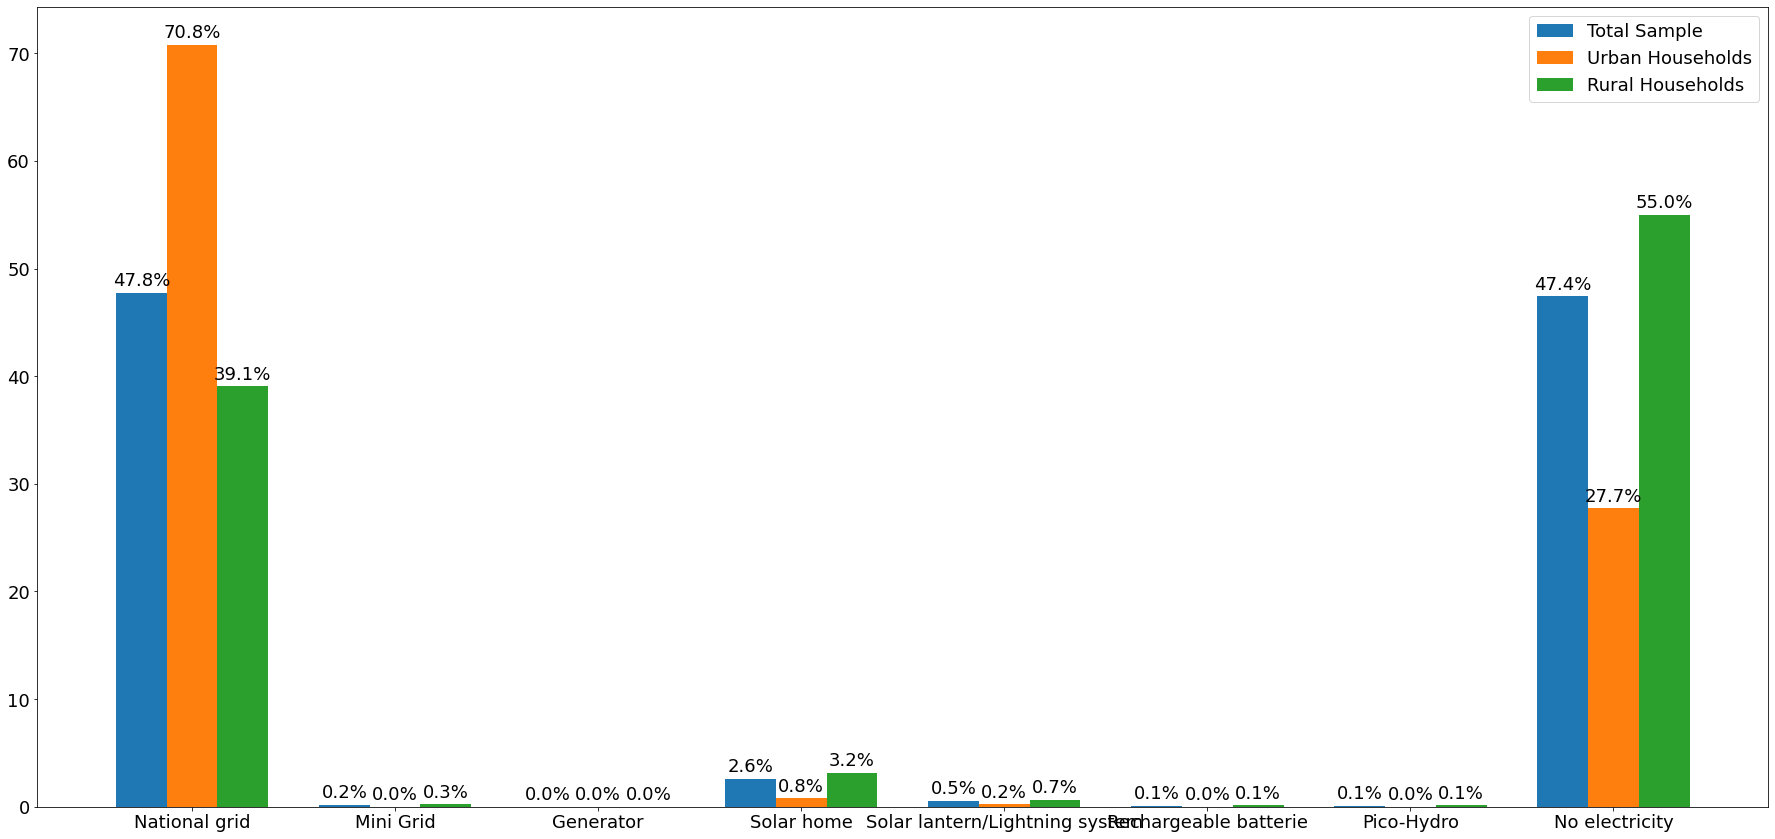

In [66]:
# grouped bar chart
labels = ['National grid','Mini Grid', 'Generator', 'Solar home', 'Solar lantern/Lightning system', 'Rechargeable batterie', 'Pico-Hydro', 'No electricity']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(25,12))
rects1 = ax.bar(x - width, tot_percent, width, label='Total Sample')
rects2 = ax.bar(x, urban_percent, width, label='Urban Households')
rects3 = ax.bar(x + width, rural_percent, width, label='Rural Households')



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
#plt.title('Proportion of household that are connected to the national grid')
plt.show()

#### Results/ Comparisons 

**According to the MTF report**

77.4% of urban households are connected to the grid, compared with 15.6% of rural
households.

Nationwide, 28.6% of households have access to at least one source of
electricity: 23.5% of households have access through the grid, and 5.1% have access through off-grid solutions.

**Here**

70.8% of urban households are connected to the grid, compared with 39.1% of rural
households.

Nationwide, 50.4% of households have access to at least one source of
electricity: 47.8% of households have access through the grid, and 2.6% have access through off-grid solutions. 


## Most serious problemsand satisfaction with the national grid connect as a main source

The questions are:

What are the most serious problems you experience with your grid electricity? C.40


How satisfied are you with the service from [MAIN SOURCE OF ELECTRICITY C.182]? if C.182 == 1 (national grid), R.8 

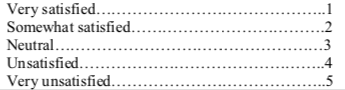

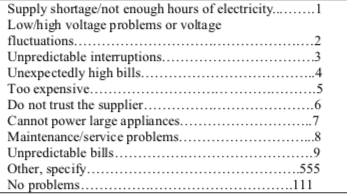

In [71]:
Image('../references/serious_pbs.png')

**According to the MTF report**


Among grid-connected households, 75.1% are satisfied with their electricity supply, and only 7.1% of grid-connected households are unsatisfied (figure 35). Although 43.2% of households do not have any problems with their supply, 26.7% of households consider unpredictable interruptions of supply a key issue, and 20.5% of households consider high cost of supply a key concern (figure 36).


In [76]:
data_grid_main_source = main[main[main_source_question] == 1]

n_expense = len(data_grid_main_source['C40_4_Unexpectedly high bills'].dropna()) + len(data_grid_main_source['C40_5_Too expensive'].dropna()) + len(data_grid_main_source['C40_9_Unpredictable bills'].dropna())
n_interruption = len(data_grid_main_source['C40_3_Unpredictable interruptions'].dropna())
n_voltage = len(data_grid_main_source['C40_2_Low/high voltage problems or voltage fluctuations'].dropna())
n_duration  = len(data_grid_main_source['C40_1_Supply shortage/not enough hours of electricity'].dropna())
n_none = len(data_grid_main_source['C40_11_No problems'].dropna())
n_other = len(data_grid_main_source['C40_10_Other'].dropna()) + len(data_grid_main_source['C40_8_Maintenance/service problems'].dropna()) + len(data_grid_main_source['C40_6_Do not trust the supplier'].dropna())+ len(data_grid_main_source['C40_7_Cannot power large appliances'].dropna())


n_tot = n_expense + n_interruption + n_voltage + n_duration + n_none + n_other

percent = [100*n_expense/n_tot, 100*n_interruption/n_tot, 100*n_voltage/n_tot,100*n_duration/n_tot,100*n_none/n_tot,100*n_other/n_tot]





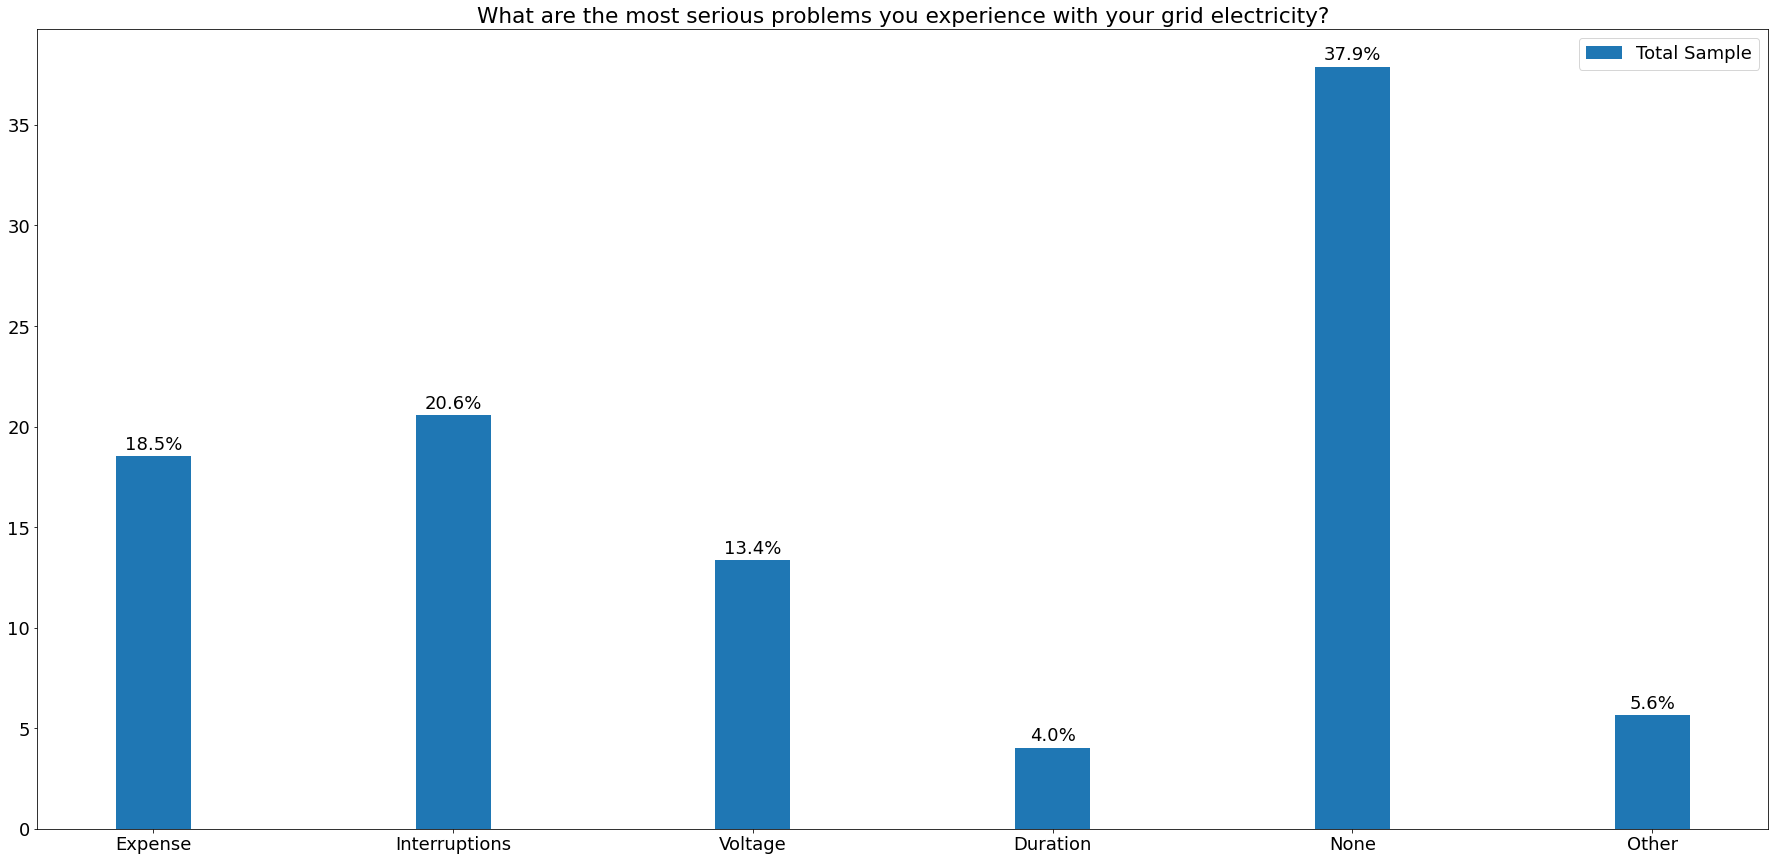

In [82]:
labels = ['Expense','Interruptions', 'Voltage', 'Duration', 'None', 'Other']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(25,12))
rects1 = ax.bar(x, percent, width, label='Total Sample')

autolabel(rects1)
fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('What are the most serious problems you experience with your grid electricity?')
plt.show()

**According to the MTF report**

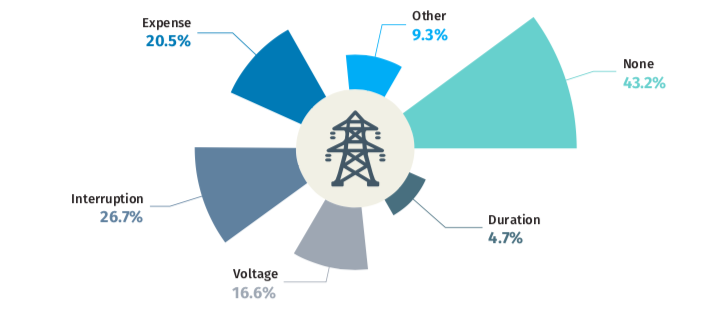

In [79]:
Image('../references/most_serious_problems.png')

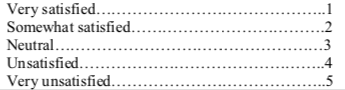

In [83]:
Image('../references/satisfaction.png')

In [86]:
n_verysat = len(data_grid_main_source[data_grid_main_source['R8_How satisfied are you with the service from the source on C182'] == 1])
n_somesat = len(data_grid_main_source[data_grid_main_source['R8_How satisfied are you with the service from the source on C182'] == 2])
n_neutral = len(data_grid_main_source[data_grid_main_source['R8_How satisfied are you with the service from the source on C182'] == 3])
n_unsat = len(data_grid_main_source[data_grid_main_source['R8_How satisfied are you with the service from the source on C182'] == 4])
n_veryunsat = len(data_grid_main_source[data_grid_main_source['R8_How satisfied are you with the service from the source on C182'] == 5])

n_tot = n_verysat + n_somesat + n_neutral + n_unsat + n_veryunsat

percent = [100*n_verysat/n_tot, 100*n_somesat/n_tot,100*n_neutral/n_tot,100*n_unsat/n_tot,100*n_veryunsat/n_tot]
    
                      

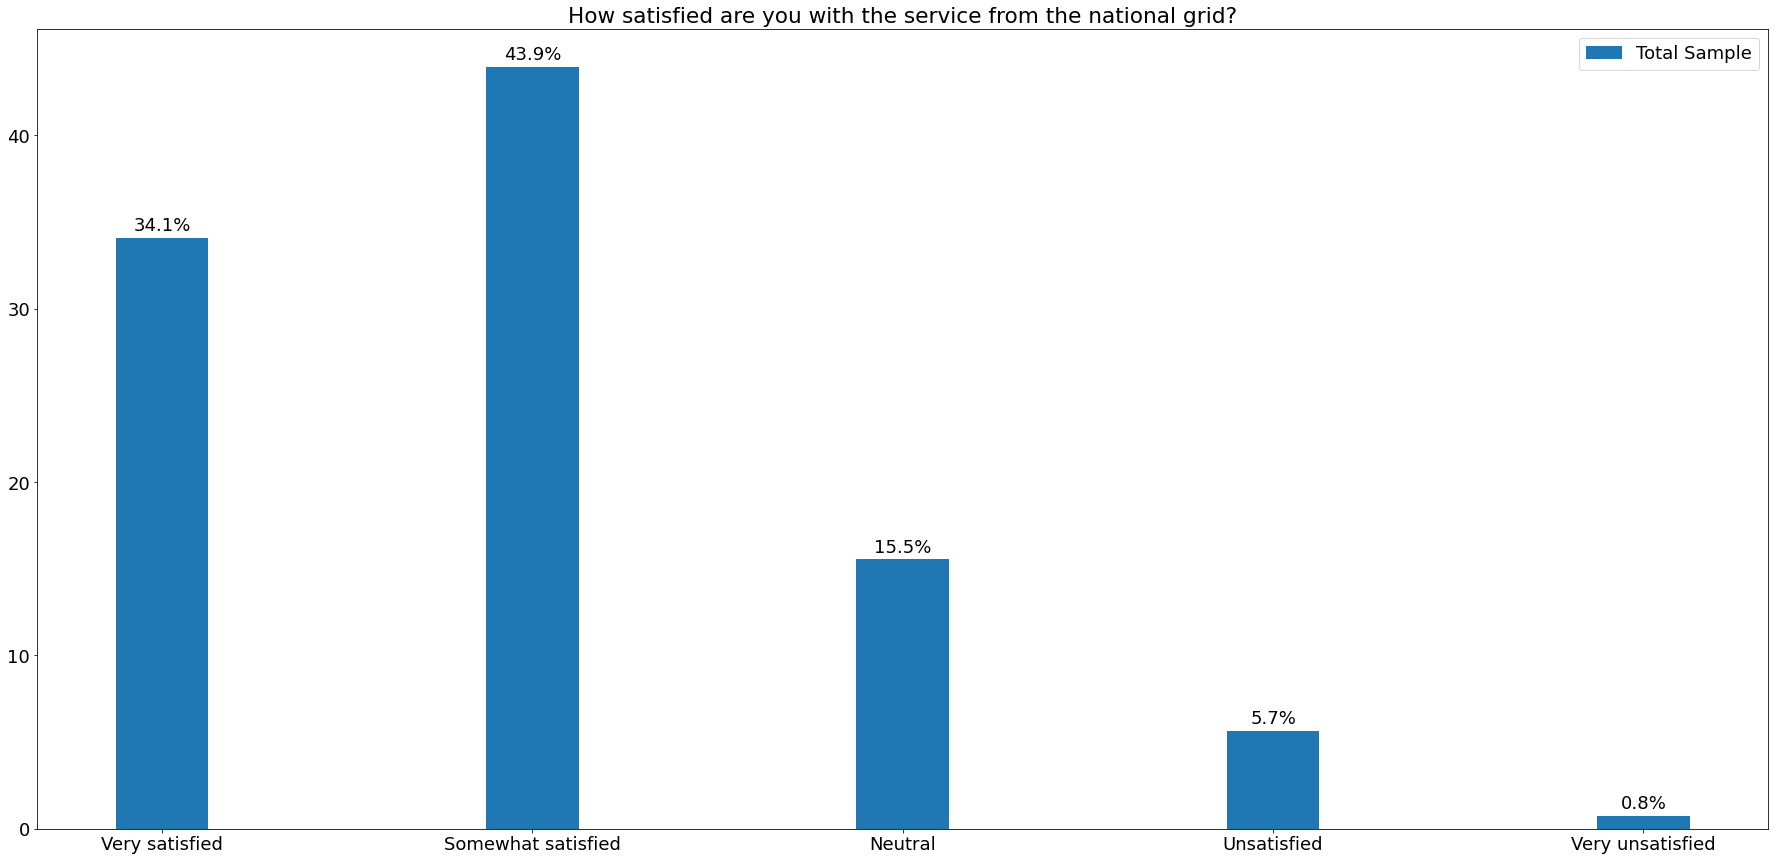

In [87]:
labels = ['Very satisfied','Somewhat satisfied', 'Neutral', 'Unsatisfied', 'Very unsatisfied']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig,ax = plt.subplots(figsize=(25,12))
rects1 = ax.bar(x, percent, width, label='Total Sample')

autolabel(rects1)
fig.tight_layout()

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('How satisfied are you with the service from the national grid?')
plt.show()

**According to the MTF report:**

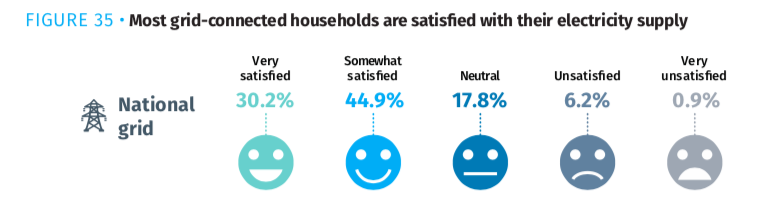

In [88]:
Image('../references/how_satisfied.png')